In [1]:
!pip install surprise

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-linux_x86_64.whl size=1199980 sha256=d0fba5c2393e89955af179dd3020d3e7d53658ba1d14d7dc9b884ba5af4dc095
  Stored in directory: /home/hshah78/.cache/pip/wheels/f4/2b/26/e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering
from collections import deque
import random
import pickle

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: NVIDIA A30


In [4]:
movie_titles = pd.read_csv('movie_titles.csv', encoding = 'ISO-8859-1', header = None, names = ['Id', 'Year', 'Name']).set_index('Id')

In [5]:
movie_titles

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [6]:
def summary_report(data):
    r, c = data.shape
    t_sparce = 0
    t_nunique = 0
    for n in data.columns:
        col = data[n]
        sparce = round(round(col.isna().sum() / r, 2) * 100, 2)
        nunique = col.nunique()
        
        t_sparce = t_sparce + sparce
        t_nunique = t_nunique + nunique
        
        print(str(n) + " is " + str(sparce) + "% empty. (" + str(data[n].isna().sum()) + " null values)")
        print(f"The column has " + str(nunique) + " unique elements.")
        print("\n")
    
    data.info()
    print(f"The shape of the dataset is " + str(r) + " rows and " + str(c) + " columns.")
    print(f"The dataset is " + str(round(c / t_sparce, 2)) + "% dense and contains " + str(t_nunique) + " unique elements." )

In [9]:
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1], low_memory=False)
df2 = pd.read_csv('combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1], low_memory=False)
df3 = pd.read_csv('combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1], low_memory=False)
df4 = pd.read_csv('combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1], low_memory=False)

df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

frames = [df1, df2, df3, df4]
df = pd.concat(frames)

df.index = np.arange(0,len(df))
df = df[1:len(df)]
tmp_movies = df[df['Rating'].isna()]['Cust_Id'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

user_data = []

for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    if df_id_1<df_id_2:
        tmp_df = df.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df.loc[df_id_1+1:].copy()
        
    tmp_df['Movie'] = movie_id
    user_data.append(tmp_df)

rating = pd.concat(user_data)
del user_data, df, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape Cust_Id-Ratings:\t{}'.format(rating.shape))
rating.sample(5)

Dataset 1 shape: (24058263, 2)
Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)
Shape Cust_Id-Ratings:	(100479960, 3)


,Cust_Id,Rating,Movie
90032264,345075,4.0,16008
35903500,2626823,2.0,6386
52767625,1686543,5.0,9598
27684811,2087505,1.0,5106
23935741,209494,5.0,4472


In [10]:
ratings = rating[['Cust_Id','Movie','Rating']]
ratings.columns = ['userId','movieId','rating']
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(100479960, 3)

<Axes: xlabel='rating', ylabel='Count'>

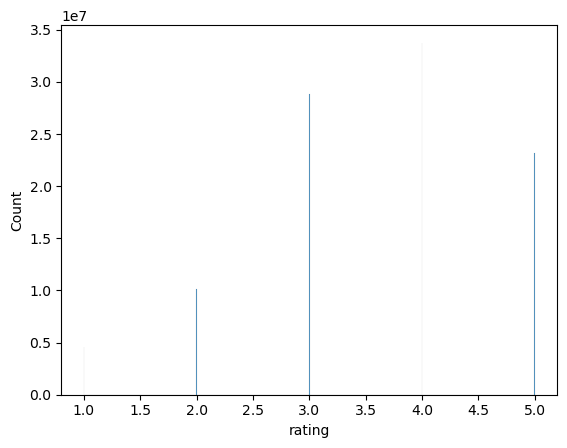

In [12]:
sns.histplot(df.sample(1000)['rating'])

In [13]:
summary_report(df)

itemID is 0.0% empty. (0 null values)
The column has 17769 unique elements.


userID is 0.0% empty. (0 null values)
The column has 480189 unique elements.


rating is 0.0% empty. (0 null values)
The column has 5 unique elements.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100479960 entries, 0 to 100479959
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   itemID  int64  
 1   userID  object 
 2   rating  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ GB
The shape of the dataset is 100479960 rows and 3 columns.
The dataset is inf% dense and contains 497963 unique elements.


In [14]:
customers = df.userID
ratings_count = dict()
for customer in customers:
    if customer in ratings_count:
        ratings_count[customer] += 1
    else:
        ratings_count[customer] = 1

<Axes: ylabel='Count'>

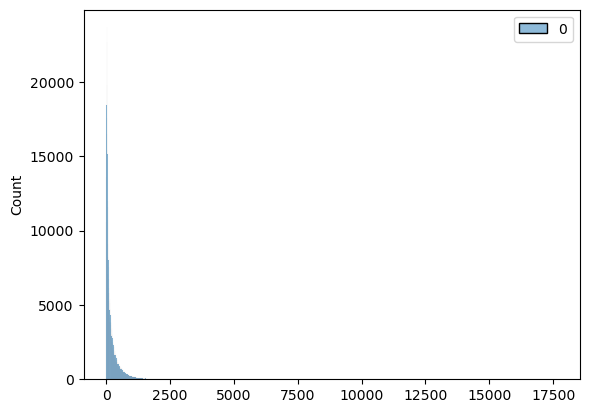

In [15]:
sns.histplot(ratings_count.values())

In [16]:
lower = 10
upper = 400
remove_customer = []
for customer, num_ratings in ratings_count.items():
    if num_ratings < lower or num_ratings > upper:
        remove_customer.append(customer)
df = df.loc[~df.userID.isin(remove_customer)]

In [17]:
summary_report(df)

itemID is 0.0% empty. (0 null values)
The column has 17768 unique elements.


userID is 0.0% empty. (0 null values)
The column has 389499 unique elements.


rating is 0.0% empty. (0 null values)
The column has 5 unique elements.


<class 'pandas.core.frame.DataFrame'>
Index: 44428923 entries, 0 to 100479953
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   itemID  int64  
 1   userID  object 
 2   rating  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ GB
The shape of the dataset is 44428923 rows and 3 columns.
The dataset is inf% dense and contains 407272 unique elements.


In [18]:
customers_edit = df.userID
ratings_count_edit = dict()
for customer in customers_edit:
    if customer in ratings_count_edit:
        ratings_count_edit[customer] += 1
    else:
        ratings_count_edit[customer] = 1

<Axes: ylabel='Count'>

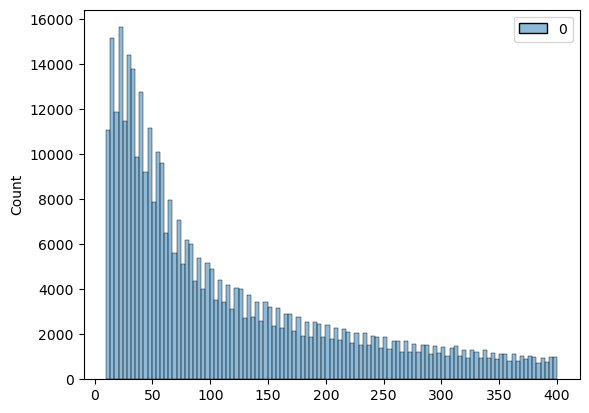

In [19]:
sns.histplot(ratings_count_edit.values())

In [20]:
movies = df.itemID
ratings_count = dict()
for movie in movies:
    if movie in ratings_count:
        ratings_count[movie] += 1
    else:
        ratings_count[movie] = 1

<Axes: ylabel='Count'>

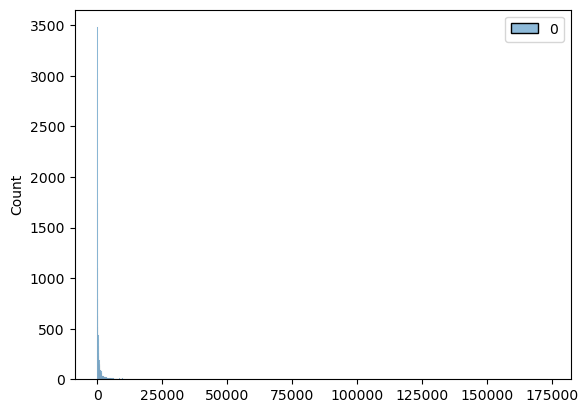

In [21]:
sns.histplot(ratings_count.values())

In [22]:
lower = 10
upper = 10000
remove_item = []
for item, num_ratings in ratings_count.items():
    if num_ratings < lower or num_ratings > upper:
        remove_item.append(item)
df = df.loc[~df.itemID.isin(remove_item)]

In [23]:
movies_edit = df.itemID
ratings_count_edit = dict()
for movie in movies_edit:
    if movie in ratings_count_edit:
        ratings_count_edit[movie] += 1
    else:
        ratings_count_edit[movie] = 1

<Axes: ylabel='Count'>

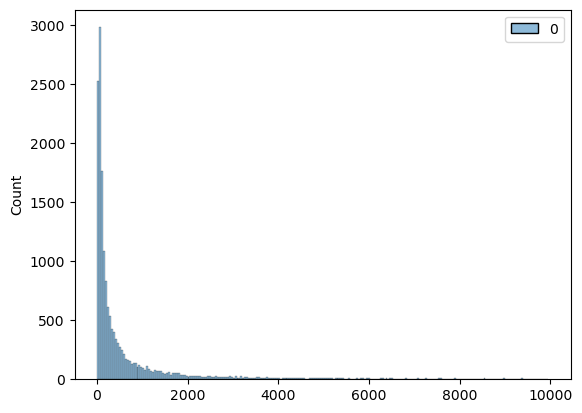

In [24]:
sns.histplot(ratings_count_edit.values())

In [25]:
summary_report(df)

itemID is 0.0% empty. (0 null values)
The column has 16801 unique elements.


userID is 0.0% empty. (0 null values)
The column has 375898 unique elements.


rating is 0.0% empty. (0 null values)
The column has 5 unique elements.


<class 'pandas.core.frame.DataFrame'>
Index: 12669476 entries, 0 to 100479953
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   itemID  int64  
 1   userID  object 
 2   rating  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 386.6+ MB
The shape of the dataset is 12669476 rows and 3 columns.
The dataset is inf% dense and contains 392704 unique elements.


In [27]:
average_count = df.groupby('itemID').mean(numeric_only = True)['rating']
play_freq = df.groupby('itemID').count()['rating']
final_play = pd.DataFrame({'avg_count':average_count,'play_freq':play_freq})
final_play = final_play.sort_values(by = 'avg_count', ascending = False)
final_play.head()

,avg_count,play_freq
itemID,,
8964,5.000000,10
14791,4.857143,35
5684,4.777778,27
12398,4.741344,491
3033,4.737374,99


In [28]:
def top_n_items(final_rating, n, min_interaction):
    recommendations = final_rating[final_rating['avg_count'] > min_interaction]
    recommendations = recommendations.sort_values(by = 'avg_count')
    return recommendations.index[:n]

top_n_items(final_play, 10, 4)

Index([5280, 10729, 14288, 9713, 6512, 9786, 9475, 17391, 9012, 5513], dtype='int64', name='itemID')

In [34]:
reader = Reader(rating_scale = (0,5))
data = Dataset.load_from_df(df[["userID", "itemID", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=.2, random_state=42)

In [36]:
trainset = data.build_full_trainset()

In [37]:
sim_options = {'name': 'cosine', 'user_based':False}

sim_user_user = KNNBasic(sim_options=sim_options, random_state=1)
sim_user_user.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [39]:
filename = 'user_user_model.pkl'
pickle.dump(sim_user_user, open(filename, 'wb'))

In [40]:
def get_recommendations(data, user_id, top_n, algo):
    recommendations = []
    user_item_interactions_matrix = data.pivot_table(index='userID', columns='itemID', values='rating')
    
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    for item_id in non_interacted_products:
        
        est = algo.predict(user_id, item_id).est
        
        recommendations.append((item_id, est))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n]

In [42]:
random_user = random.choice(list(df.userID))
recommendations = get_recommendations(df, str(random_user), 5, sim_user_user)
print(recommendations)

[(14518, 5), (4860, 4.8), (9504, 4.71403585248571), (5098, 4.5), (12888, 4.5)]


In [43]:
def ranking_items(recommendations, final_rating):
    ranked_items = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending = False)[['play_freq']].reset_index()
    ranked_items = ranked_items.merge(pd.DataFrame(recommendations, columns = ['itemID', 'predicted_ratings']), on = ['itemID'], how = 'inner')
    ranked_items['corrected_ratings'] = ranked_items['predicted_ratings'] - 1 / np.sqrt(ranked_items['play_freq'])
    ranked_items = ranked_items.sort_values('corrected_ratings', ascending = False)
    return ranked_items

In [44]:
ranking_items(recommendations, final_play)

,itemID,play_freq,predicted_ratings,corrected_ratings
4,14518,10,5.000000,4.683772
2,4860,28,4.800000,4.611018
0,9504,41,4.714036,4.557862
1,5098,37,4.500000,4.335601
3,12888,26,4.500000,4.303884


In [45]:
svd = SVD()
svd.fit(trainset)

In [47]:
filename = 'svd_model.pkl'
pickle.dump(svd, open(filename, 'wb'))

In [48]:
random_user = random.choice(list(df.userID))
random_item = random.choice(list(df.itemID))

svd.predict(random_user, random_item)

Prediction(uid='2075270', iid=8099, r_ui=None, est=3.2279859550378003, details={'was_impossible': False})

In [49]:
CoCluster = CoClustering()

CoCluster.fit(trainset)

In [50]:
filename = 'cocluster_model.pkl'
pickle.dump(CoCluster, open(filename, 'wb'))

In [51]:
random_user = random.choice(list(df.userID))
random_item = random.choice(list(df.itemID))

CoCluster.predict(random_user, random_item)

Prediction(uid='552966', iid=3364, r_ui=None, est=3.4492601107833187, details={'was_impossible': False})